## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy

from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
import itertools

from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

print ('Library loaded')

Library loaded


In [2]:
inp = '../input/skin-cancer-mnist-ham10000/'
os.listdir(inp)

['hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv']

### Create the directory structure

In these folders we will store the images that will later be fed to the Keras generators.

In [3]:
folders_to_create = ["HAM10000_224new"]


def create_folders(folders):
    for folder in folders:
        folder_path = os.path.join(folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Folder '{folder}' sudah dibuat.")
        else:
            print(f"Folder '{folder}' sudah ada.")


create_folders(folders_to_create)

Folder 'HAM10000_224new' sudah dibuat.


### Create Train and Val Sets

In [4]:
base = 'HAM10000_224new'

data_pd = pd.read_csv(inp+'HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
train_dir = os.path.join(base, "train_dir")
test_dir = os.path.join(base, "test_dir")

In [6]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [7]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [8]:
#Memeriksa apakah terdapat gambar yang memiliki duplikat
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no'
    else:
        return 'duplicates'

data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [9]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

data_pd['is_duplicate'].value_counts()

no            5514
duplicates    4501
Name: is_duplicate, dtype: int64

In [10]:
#Melihat gambar-gambar yang terduplikat
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

data_pd.dx=data_pd.dx.astype('category',copy=True)
data_pd['label']=data_pd.dx.cat.codes # Convert the labels to numbers
data_pd['lesion_type']= data_pd.dx.map(lesion_type_dict)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,label,lesion_type
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,2,Benign keratosis


In [11]:
#Total gambar perkelas
class_counts = data_pd['lesion_type'].value_counts()
print(class_counts)

Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion_type, dtype: int64


In [12]:
# #Split test data 20%
train, test_df = train_test_split(df_count, test_size=0.20, stratify=df_count['dx'])


In [13]:
#Memeriksa tiap gambar masuk kedalam jenis train atau test
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#membuat train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,label,lesion_type,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,2,Benign keratosis,train


In [14]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
5702,HAM_0002743,ISIC_0030439,nv,follow_up,40.0,male,abdomen,no
1930,HAM_0005926,ISIC_0027069,mel,histo,75.0,male,back,no
8034,HAM_0002597,ISIC_0033045,nv,consensus,25.0,male,unknown,no
3328,HAM_0002066,ISIC_0030936,nv,follow_up,45.0,female,back,no
5201,HAM_0002935,ISIC_0024670,nv,follow_up,45.0,male,trunk,no


In [15]:
#membagi kelas
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

#Total data untuk train dan test
print(len(train_list))
print(len(test_list))

8912
1103


In [16]:
data_pd.set_index('image_id', inplace=True)

In [17]:
#membuat berkas train
os.mkdir(train_dir)
os.mkdir(test_dir)

In [18]:
classname = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
for i in classname:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

folder_1 = os.listdir(inp+'ham10000_images_part_1')
folder_2 = os.listdir(inp+'ham10000_images_part_2')

# memasukkan gambar ke train set
for image in train_list:
    fname = image + '.jpg'
    label = data_pd.loc[image, 'dx']

    if fname in folder_1:
        src = os.path.join(inp+'ham10000_images_part_1', fname)
        dst = os.path.join(train_dir, label, fname)
        
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(inp+'ham10000_images_part_2', fname)
        dst = os.path.join(train_dir, label, fname)
        
        shutil.copyfile(src, dst)

#  memasukkan gambar ke test set
for image in test_list:
    fname = image + '.jpg'
    label = data_pd.loc[image, 'dx']

    if fname in folder_1:
        src = os.path.join(inp+'ham10000_images_part_1', fname)
        dst = os.path.join(test_dir, label, fname)
        
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(inp+'ham10000_images_part_2', fname)
        dst = os.path.join(test_dir, label, fname)
        
        shutil.copyfile(src, dst)

# menghitung total gambar tiap kelas train set
train_class_counts = train_df['lesion_type'].value_counts()
print("Train File Class Counts:")
print(train_class_counts)

Train File Class Counts:
Melanocytic nevi        5822
Melanoma                1067
Benign keratosis        1011
Basal cell carcinoma     479
Actinic keratoses        297
Vascular lesions         129
Dermatofibroma           107
Name: lesion_type, dtype: int64


In [19]:
#augmentasi gambar
classname = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
for img_class in classname:
    aug_dir = os.path.join(base, "aug_dir")
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, "img_dir")
    os.mkdir(img_dir)

    img_list = os.listdir(
        os.path.join(base, "train_dir", img_class)
    )
    for file_name in img_list:
        source = os.path.join(
            base, "train_dir", img_class, file_name
        )
        target = os.path.join(img_dir, file_name)
        shutil.copyfile(source, target)

    source_path = aug_dir
    save_path = os.path.join(base, "train_dir", img_class)
    batch_size = 50

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.05,
    )

    aug_datagen = datagen.flow_from_directory(
        source_path,
        save_to_dir=save_path,
        save_format="jpg",
        target_size=(224, 224),
        batch_size=batch_size,
    )
    aug_images = 6000

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # hapus temporary directory
    shutil.rmtree(aug_dir)

Found 297 images belonging to 1 classes.
Found 479 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.
Found 107 images belonging to 1 classes.
Found 1067 images belonging to 1 classes.
Found 5822 images belonging to 1 classes.
Found 129 images belonging to 1 classes.


In [20]:
#menghitung total kelas setelah augmentasi pada train set
def count_images_per_class(directory):
    class_counts = {}

    for img_class in os.listdir(directory):
        class_path = os.path.join(directory, img_class)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[img_class] = num_images

    return class_counts


augmented_train_dir = os.path.join(base, "train_dir")

augmented_class_counts = count_images_per_class(augmented_train_dir)

print("Banyak gambar per kelas pada train_df setelah augmentasi:")
for img_class, count in augmented_class_counts.items():
    print(f"{img_class}: {count} images")

Banyak gambar per kelas pada train_df setelah augmentasi:
df: 4330 images
nv: 6022 images
bkl: 5855 images
mel: 5885 images
bcc: 5798 images
akiec: 5990 images
vasc: 5210 images


In [21]:
# melihat banyaknya total gambar tiap kelas
test_class_counts = test_df["dx"].value_counts()
print("Banyak gambar per kelas pada test_df:")
print(test_class_counts)

Banyak gambar per kelas pada test_df:
nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64


### Training Model

In [30]:
train_path = '/kaggle/working/HAM10000_224new/train_dir'
test_path = '/kaggle/working/HAM10000_224new/test_dir'

batch_size = 32

image_size = 224

In [31]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=False)


Found 39090 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [57]:
base_mobilenet = tf.keras.applications.MobileNetV2(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)
for layer in base_mobilenet.layers:
    layer.trainable = False

for layer in base_mobilenet.layers[-7:]:
    layer.trainable = True


In [58]:
#MobileNetV2
model = Sequential()
model.add(base_mobilenet)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                40992     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 7)                

In [60]:
model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=["acc"],
)

In [61]:
#VGG16
checkpoint = ModelCheckpoint(
    filepath="MobileNetV2fix.hdf5",
    monitor="val_acc",
    save_best_only=True,
    verbose=1,
    mode="max",
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=0.00001,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

In [62]:
history = model.fit(
    train_batches,
    steps_per_epoch=(len(train_df) // batch_size),
    epochs=40,
    verbose=1,
    validation_data=test_batches,
    validation_steps=(len(test_df) // batch_size),
    callbacks=[checkpoint, reduce_lr, early_stopping],
)

Epoch 1/40
278/278 [==============================] - 42s 141ms/step - loss: 1.2696 - acc: 0.5638 - val_loss: 8.4088 - val_acc: 0.0873

Epoch 00001: val_acc improved from -inf to 0.08732, saving model to MobileNetV2fix.hdf5
Epoch 2/40
278/278 [==============================] - 39s 139ms/step - loss: 0.9765 - acc: 0.6497 - val_loss: 1.1474 - val_acc: 0.7950

Epoch 00002: val_acc improved from 0.08732 to 0.79504, saving model to MobileNetV2fix.hdf5
Epoch 3/40
278/278 [==============================] - 38s 138ms/step - loss: 0.8881 - acc: 0.6876 - val_loss: 1.6996 - val_acc: 0.6700

Epoch 00003: val_acc did not improve from 0.79504
Epoch 4/40
278/278 [==============================] - 38s 138ms/step - loss: 0.8162 - acc: 0.7095 - val_loss: 0.9947 - val_acc: 0.7941

Epoch 00004: val_acc did not improve from 0.79504

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/40
278/278 [==============================] - 38s 138ms/step - loss: 0.7354 - acc: 0.743

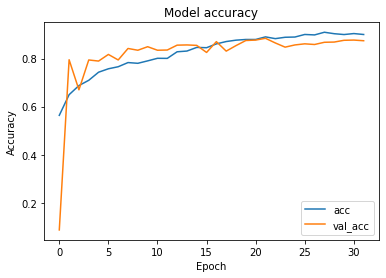

In [63]:
# plot grafik akurasi
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")
plt.show()

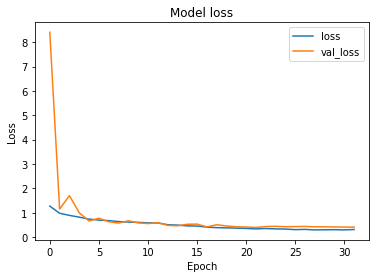

In [64]:
# plot grafik loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")
plt.show()

In [65]:
# model.save("VGG16.hdf5")
model.save("MobileNetV2fix.hdf5")

In [66]:
train_score = model.evaluate(train_batches, verbose=1)
test_score = model.evaluate(test_batches, verbose=1)

print("Train loss: ", train_score[0])
print("Train acc: ", train_score[1])
print("-" * 75)
print("Test loss: ", test_score[0])
print("Test acc: ", test_score[1])

35/35 [==============================] - 10s 279ms/step - loss: 0.4078 - acc: 0.8821
Train loss:  0.227561816573143
Train acc:  0.9226400852203369
---------------------------------------------------------------------------
Test loss:  0.4077904224395752
Test acc:  0.8821396231651306


In [67]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


34/34 [==============================] - 10s 282ms/step

Classification Report:
               precision    recall  f1-score   support

       akiec    0.51852   0.46667   0.49123        30
         bcc    0.61538   0.45714   0.52459        35
         bkl    0.64773   0.64773   0.64773        88
          df    0.25000   0.12500   0.16667         8
         mel    0.58621   0.36957   0.45333        46
          nv    0.93675   0.97282   0.95444       883
        vasc    0.75000   0.69231   0.72000        13

    accuracy                        0.88214      1103
   macro avg    0.61494   0.53303   0.56543      1103
weighted avg    0.87032   0.88214   0.87436      1103



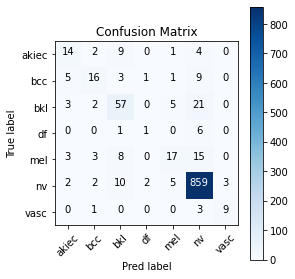

In [68]:
true_labels = test_batches.classes
model.load_weights("MobileNetV2fix.hdf5")

#model.load_weights("VGG16.hdf5")
predictions = model.predict(test_batches, steps=len(test_df) / batch_size, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(4, 4))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [69]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


Found 39090 images belonging to 7 classes.
1222/1222 [==============================] - 121s 99ms/step

Training Classification Report:
               precision    recall  f1-score   support

       akiec    0.94740   0.93523   0.94128      5990
         bcc    0.95431   0.94740   0.95084      5798
         bkl    0.83058   0.85909   0.84460      5855
          df    0.97391   0.99145   0.98260      4330
         mel    0.88219   0.80289   0.84067      5885
          nv    0.89517   0.95002   0.92178      6022
        vasc    0.99846   0.99846   0.99846      5210

    accuracy                        0.92264     39090
   macro avg    0.92600   0.92636   0.92575     39090
weighted avg    0.92281   0.92264   0.92226     39090



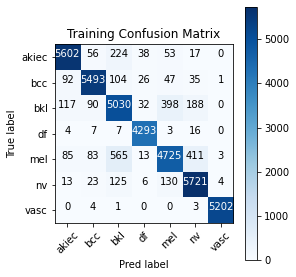

In [70]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(4, 4))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()